# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

<img src="examples/laneLines_thirdPass.jpg" width="480" alt="Combined Image" />


## Overview
---

**Finding Lane Lines on the Road**

How does the algorithm recognize the lane lines?

First, we must understand how do human recognize the lane lines. There are many ways we can characterize the lane lines, however for most people we intutively recognize the lane lines by features like color, position and shape, just like how we learn to recognize any other objects or person.

To recognize the lane lines, we can apply the same techniques to teach the computer to do the same. Naturally we can treat the things we see with our eyes as a video stream or sets of moving images. And for computers to perceive the moving images like us, we need to undertand the information stored in the image and how can we extract useful features from it such as edge detection using Canny Edge detection algorithm, as well as finding lines from the detected edges using Hough transform algorithm.



## Goal
---

The goal of this lane finding project is to track the lane lines on the road and draw the lines over the lane lines on the road. To do that, a series of computer vision pipelines (using openCV) is built to analyze the video stream.

## Import Packages

In [1]:
# Import some useful packages
import numpy as np
import cv2
import os
import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Import linear regression model
from sklearn.linear_model import LinearRegression

# Import visualization packages
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Magic word to display the figure inline in the Jupyter notebook
%matplotlib inline

## Basic Colors
Define basic colors for repeat in the pipeline

In [2]:
# RGB colors
red = (255,0,0)
yellow = (255,255,0)
blue = (0,0,255)

## Helper Functions to read/show/compare Images

In [3]:
def get_image_path(img_name):
    """Get the full path of the image file"""
    img_folder = 'test_images/'
    
    # Construct the full image path
    return img_folder + img_name

def show_image(image):
    """Show a single image and the dimensions"""
    # Read in an image
    image = mpimg.imread(image)

    # Print out image dimensions and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

def show_images(images,rows,columns,grid_size=10):
    """
    Show images in grid
    
    images      : the images dictionary (output from store_images())
    rows        : number of rows in the table
    columns     : number of columns in the table
    [grid_size] : size of the image grid to display in inches
    """
    
    fig = plt.figure(figsize=(grid_size, grid_size))
    
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        for key, value in images[i-1].items():
            # Get the curent subplot and change the title
            plt.gca().set_title(key)
            plt.imshow(value)
    plt.show()
    
def store_images(dir):
    """
    Store images from the directory to dictionary
    
    Retuns a dictionary of the image filename
    and the image
    
    dir : directory contains images
    """
    
    img_files_list = os.listdir(dir)
    images_dict = []
    
    for img_file_name in img_files_list:
        if(img_file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))):
            img_dict = {}

            # Read the image and store the image filename
            # and the image in the dictionary
            img = mpimg.imread(dir+img_file_name)
            img_dict[img_file_name] = img;
            images_dict.append(img_dict)
    return images_dict

def compare_two_images(img1,img2,title1='',title2='',bgcolor='white',font_color='black'):
    """
    Compare two images side by side
    Return HTML tag to display the images on the same line

    img1         : first image
    img2         : second image
    [title1]     : title for the first image
    [title2]     : title for the second image
    [bgcolor]    : background color - default set to white
    [font_color] : font color - default to black
    """
    
    # Set default video heading and titles if it was left empty
    if (not title1):
        title1 = img1
    if (not title2):
        title2 = img2
    return HTML("""
    <div id="videoal" align="middle">
        <table>
            <tr>
                <td style="text-align: center; vertical-align: middle;" bgcolor={4}><font color={5}>{0}</font></td>
                <td style="text-align: center; vertical-align: middle;" bgcolor={4}><font color={5}>{1}</font></td>
            </tr>
            <tr>
                <td>
                    <img src ="{2}">
                </td>
                <td>
                    <img src ="{3}">
                </td>
            </tr>
        </table>
    </div>""".format(title1,title2,img1,img2,bgcolor,font_color))

## Show Test Images

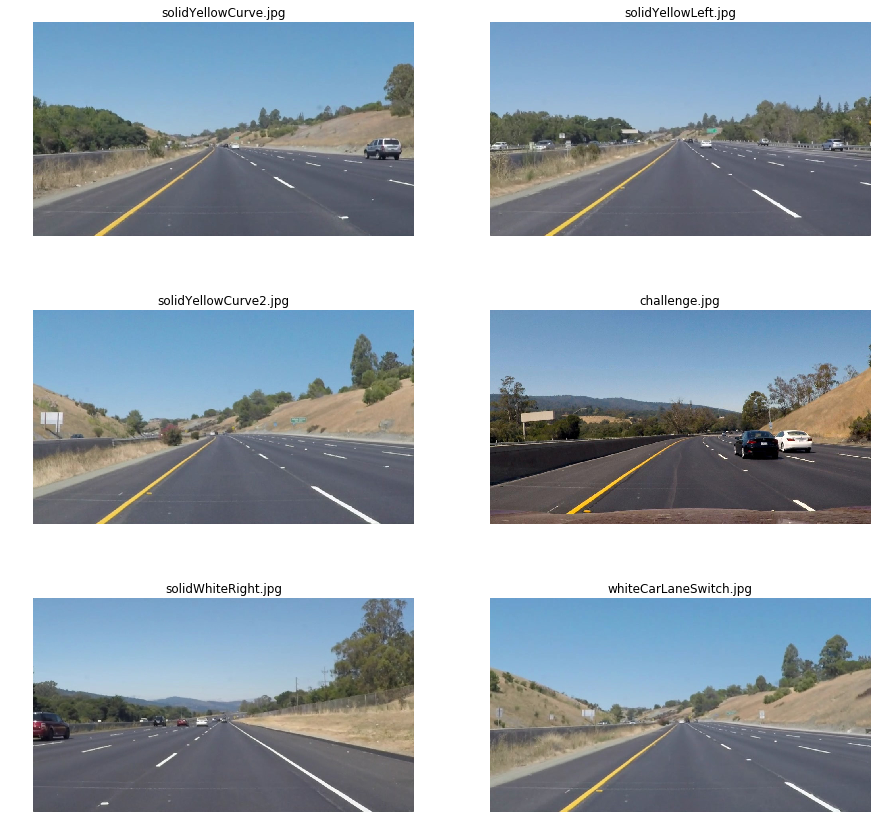

In [4]:
# Show single image
# show_image('test_images/solidWhiteRight.jpg')

# Read and show all images in the "test_images" folder
test_images = store_images("test_images/")
show_images(test_images,rows=3,columns=2,grid_size=15)

## Udacity's Helper Functions

In [5]:
def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, ratio, lower_threshold, upper_threshold, scaler=1):
    """Apply the Canny edge detection"""
    return cv2.Canny(img, lower_threshold*ratio*scaler, upper_threshold*ratio*scaler)

def gaussian_blur(img, kernel_size):
    """Apply a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Helper Functions to Compare Videos
Ideal for visualizing generated videos on the fly

In [6]:
def show_video(video):
    """
    Show a single video clip
    """
    return HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video))

def compare_two_videos(video1,video2,title1='',title2='',bgcolor='white',font_color='black'):
    # Set default video heading and titles if it was left empty
    if (not title1):
        title1 = video1
    if (not title2):
        title2 = video2
    return HTML("""
    <div id="videoal" align="middle">
        <table>
            <tr>
                <td style="text-align: center; vertical-align: middle;" bgcolor={4}><font color={5}>{0}</font></td>
                <td style="text-align: center; vertical-align: middle;" bgcolor={4}><font color={5}>{1}</font></td>
            </tr>
            <tr>
                <td>
                    <video width="100%" controls>
                        <source src="{2}" type="video/mp4">
                    </video>
                </td>
                <td>
                   <video width="100%" controls>
                      <source src="{3}" type="video/mp4">
                   </video>
                </td>
            </tr>
        </table>
    </div>""".format(title1,title2,video1,video2,bgcolor,font_color))

## Helper functions to capture frames from videos

In [7]:
def create_timestamps(start,end,step,decimal_places=2):
    """
    Create equally spaced timestamps
    start : start time in seconds
    end   : end time in seconds
    step  : step time in seconds
    """
    
    # Create a equally spaced array
    myList = np.arange(start,end,step).tolist()
    
    # Round off the generated numbers to two decimal places
    # after array is converted to list
    return [round(elem,decimal_places) for elem in myList]

# Adapted from https://stackoverflow.com/questions/43148590/extract-images-using-opencv-and-python-or-moviepy
def extract_video_frames(video, timestamps, target_img_dir,free_text=''):
    """
    Extract images from the video frames
    Store images in the image folder with the format of:
    video[free_text]_time_s.jpg
    
    video         : the full video path
    timestamps    : the timestamps in seconds. For example:
                    1, 1.5, 2.7 => 1sec, 1.5sec and 2.7secs
    target_img_dir: the folder path where the images are stored
    [free_text]   : optional free text to include in the filename
    """
    
    # Split the filename and the file extensions
    folder, filename = os.path.split(video)
    filename_wo_ext, extension = os.path.splitext(filename)
    clip = VideoFileClip(video)
    
    # Construct new file name and store it in the target image folder
    for t in timestamps:
        imgpath = os.path.join(target_img_dir, filename_wo_ext+free_text+'_time_'+'{}s.jpg'.format(t))
        clip.save_frame(imgpath, t)


"""
Example of using extract_video_frames to store images
between the 2 and 9 secs at every 0.1 sec
"""
# video_path = "test_videos_output/solidWhiteRight.mp4"
# target_img_dir = "test_videos_output"
# timestamps = create_timestamps(2,9,0.1)
# extract_video_frames(video_path, timestamps, target_img_dir)

"""
Another example of using extract_video_frames to store images
between the 3.6 and 3.74 secs at every 0.01 sec
"""
# source_video_dir = 'test_videos_output/'
# video_name = 'challenge.mp4'
# video_path = source_video_dir + video_name
# target_img_dir = 'test_videos_output/'
# timestamps = create_timestamps(3.6,3.74,0.01)
# extract_video_frames(video_path, timestamps, target_img_dir)

'\nAnother example of using extract_video_frames to store images\nbetween the 3.6 and 3.74 secs at every 0.01 sec\n'

# <font color = 'blue'> Background about the lane finding pipeline</font>

## Image, Color Space (RGB, HSV, HLS) and Color Masks 

How can the algorithm recognize the lane lines?

First, we must understand how do we (human) recognize the lane lines. There are many ways we can characterize the lane lines, however for most people we intutively recognize the lane lines by features like color, position and shape, just like how we learn to recognize any other objects or person.

To recognize the lane lines, we can apply the same techniques to teach the computer to do the same. Naturally we can treat the things we see with our eyes as a video stream or sets of moving images. And for computers to perceive the moving images like us, we need to undertand the information stored in the image and how can we extract useful features from it such as edge detection using Canny Edge detection algorithm, as well as finding lines from the detected edges using Hough transform algorithm.

An image is made up number of pixels of different colors in 3 RGB color layers (Red,Green,Blue), and an image file stores the color-pixel in stacks of arrays, each for different color channel.

### How do color space and color masks relate to finding lane lines and why they are important? 

Since images are stored in different color channels, it makes it easy to find the white and yellow lines or lanes if we can consider only the white and yellow pixels in the image. Here is a good example on using [OpenCV and Python for Color Detection](https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/)

There are many different methods to filter/extract the colors from the image, images can be represented in a number of different color space such as RGB, HSV and HLS. [Source: Color Space on Wiki](https://en.wikipedia.org/wiki/Color_space).

In this notebook, RGB and HLS color masks were experimented for finding the optimum mask for lanes finding. 

### Different Conventions of RGB and BGR color order
By default the OpenCV uses the BGR color order for images i.e. ```imread()``` and ```imwrite()```, whereas the matplotlib uses the RGB color for to display image. It is important not to mix them up.

More information on: why OpenCV uses BGR color order can be found [here](https://www.learnopencv.com/why-does-opencv-use-bgr-color-format/)

## Lane Lines Finding Pipelines


1. **Color Filtering** - `select_color_mask()` <br>Select white and yellow color by using color masks (RGB/HSV/HLS). * **HLS** * color mask yields the most consistent color filtering in this project


2. **Grayscale** - `grayscale()` <br> Convert the image color to grayscale for Canny edge detection 


3. **Blurring** - `gaussian_blur()` <br> Blur the image using Gaussian blur transformation for smoother edge detection 


4. **Edge detection**  - `canny()` <br> Detect edges using Canny edge detection algorithm 


5. **Region of Interest**
    1. `select_polygon_vertices()` <br> Select the region of interest for the detected edges
    2. `select_masked_edges()` <br> Mask the detected edges with region of interest
  
  
6. **Hough Lines** `select_hough_lines()` <br> Apply Hough Lines transform to find lines using masked edges


7. ** Paritioning the lines & Averaging and Extrapolating Lines **
    1. **Paritioning the lines** `partition_lines()` <br> Paritioning the lines to find left and right lanes
    2. **Averaging and Extrapolating lines** `avg_extrapolated_lines()` <br> Apply average and extra-polate algorithm (linear regression / polyfit) to find a straight line to track the lane line
    
    
8. **Process images in series** `process_video()`<br> Apply all of the above image processing steps `process_image()` with a series of images using `moviepy.editor`


During the development of the pipeline, it is tested on a number of test images for verifications of the lane tracking performance under various conditions and parameters tuning. Once the output of the test images are satisified, the pipeline is followed by testing on a number of test videos to verify the lane line tracking in real-time.

Initially when the `draw_lines()` function was used, the lane line finding pipeline was only able to draw the line segments that were identified by Hough Transform (from the output of the Canny edges).

In order to improve the robustness of the lane line finding and able to mark the lanes clearly with a solid line, two additional stages are added to enhance the lane finding pipeline:

- Partitioning the left / right lane lines based on the line slope
- Approximation of a straight line that fits to each of the left/right lane lines

### [Tuning] Color Mask Thresholds:
The lower and upper threshold affects on the sensivity in selecting the white and yellow colors. If the range between these two thresholds is too small, then this may require the Canny edge detection thresholds to be more sensitive, vice versa.

## RGB Mask

In [8]:
def select_rgb_white(img):
    """
    Filter only the white color
    using RGB color space
    
    img: RGB format image
    
    Return white RGB color mask
    """
    
    lower = np.uint([200, 200, 200])
    upper = np.uint([255, 255, 255])
    return cv2.inRange(img, lower, upper)    

def select_rgb_yellow(img):
    """
    Filter only the yellow color
    using RGB color space
    
    img: RGB format image
    
    Return yellow RGB color mask
    """
    
    lower = np.uint([200, 200, 0])
    upper = np.uint([255, 255, 255])  
    return cv2.inRange(img, lower, upper)

When more than one colors need to be extracted from an image, it is often to use a combination of color masks by using ```cv2.bitwise_or``` to combine the color mask and then using ```cv2.bitwise_and``` operation to apply the combined masks with an image.

In [9]:
def combine_img_masks(mask1,mask2):
    """Return combined image masks"""
    return cv2.bitwise_or(mask1, mask2)

In [10]:
def select_rgb_white_yellow(img,show=False):
    """
    Mask the image with combined RGB color masks
    to select white and yellow (lane lines)
    
    img: RGB format image
    
    Return masked image with white
    and yellow color
    """
    
    white_rgb_mask = select_rgb_white(img)
    yellow_rgb_mask = select_rgb_yellow(img)
    
    # Combine masks and apply it to the image
    white_yellow_rgb_mask = combine_img_masks(white_rgb_mask, yellow_rgb_mask)
    masked_img = cv2.bitwise_and(img, img, mask=white_yellow_rgb_mask) 
    return masked_img

Similiarly, color masks in HLS color space can also be used to extract the white and yellow colors of an image. Since the test image is already in the RGB format, therefore we must first convert it to the HLS color space using [```cv2.cvtColor(image, cv2.COLOR_RGB2HLS)```](https://docs.opencv.org/3.1.0/d7/d1b/group__imgproc__misc.html)

## HLS Mask

In [11]:
def select_hls_white(img):
    """
    Filter only the white color
    using HLS color space
    
    img: HLS format image
    
    Return white HLS color mask
    """
    
    # Convert RGB image to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # White hls mask
    lower = np.uint([0, 200, 0])
    upper = np.uint([255, 255, 255])
    return cv2.inRange(hls_img, lower, upper)

def select_hls_yellow(img):
    """
    Filter only the yellow color
    using HLS color space
    
    img: HLS format image
    
    Return yellow RGB color mask
    """
    
    # Convert image to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Yellow hls mask
    lower = np.uint([10, 0, 100])
    upper = np.uint([40, 255, 255])
    return cv2.inRange(hls_img, lower, upper)

def select_hls_white_yellow(img):
    """
    Mask the image with combined HLS color masks
    to select white and yellow (lane lines)
    
    img: HLS format image
    
    Return masked image with white
    and yellow color
    """
    
    white_hls_mask = select_hls_white(img)
    yellow_hls_mask = select_hls_yellow(img)
    
    # Combine masks and apply it to the image
    white_yellow_hls_mask = combine_img_masks(white_hls_mask, yellow_hls_mask)
    masked_img = cv2.bitwise_and(img, img, mask=white_yellow_hls_mask) 
    return masked_img

***
# Evaluation of Color Masks (RGB, HSV, HLS)
## Color Mask Performance Evaluation:  White lines only

To evaluate the performance of the ability of the color filtering the white color of the mask, both  RGB and HSL color mask were applied to the test video named 'solidWhiteRight.mp4' containing __solid and segmented white lines__

<figure>
 <img src="test_images/solidWhiteCurve.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Solid and segmented white lines </p> 
 </figcaption>
</figure>
 <p></p> 

### RGB vs HLS Image Comparison: White lines only (t = 2s)
<table>
    <tr>
        <td> <img src="report_images/rgb_vs_hls_mask/solidWhiteRight_time_rgb_2s.jpg" alt="Drawing"/> </td>
        <td> <img src="report_images/rgb_vs_hls_mask/solidWhiteRight_time_hls_2s.jpg" alt="Drawing"/> </td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;" bgcolor="white"> RGB color mask filters the line well </td>
        <td style="text-align: center; vertical-align: middle;" bgcolor="white"> HLS color mask picks up some road noises </td>
    </tr>
</table>

#### <font color = 'green'> In this case, RGB color mask performs for better noise rejection </font>

The RGB color mask in this sceneario performs slightly better than the HLS, as the HLS masked video also picks up the unwanted noises such as yellow road sign and the lawn on the right. However, this slight imperfection of HLS mask should not be a problem, as later we can apply ```region of interest``` to specifically crop the non-road regions.

The following videos on the left and right are the result of applying colormask of RGB and HLS to the test video respectively. As we can see in the videos, both RGB and HLS mask are able to effectively filter for the white solid and segmented lines very well.

### RGB vs HLS Video Comparison: Solid white line on right

<tr>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> RGB Mask </td>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> HLS Mask </td>
</tr>
<tr>
    <td> <video width="100%" controls src="test_videos_output/1_white_yellow_rgb_mask/solidWhiteRight.mp4"/> </td>
    <td> <video width="100%" controls src="test_videos_output/1_white_yellow_hls_mask/solidWhiteRight.mp4"/> </td>
</tr>

***
## Color Mask Performance Evaluation:  Yellow line

To evaluate the performance of the ability of the color filtering the white and yellow color of the mask, both the RGB and HSL color masks are applied to the test video named 'solidYellowLeft.mp4' containing __solid yellow line on left__

<figure>
 <img src="test_images/solidYellowLeft.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Solid yellow line on left </p> 
 </figcaption>
</figure>
 <p></p>
 
<table>
    <tr>
        <td> <img src="report_images/rgb_vs_hls_mask/solidYellowLeft_rgb_time_11.6s.jpg" alt="Drawing"/> </td>
        <td> <img src="report_images/rgb_vs_hls_mask/solidYellowLeft_hls_time_11.6s.jpg" alt="Drawing"/> </td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;" bgcolor="white"> RGB color mask is having difficulties retaining the yellow pixel </td>
        <td style="text-align: center; vertical-align: middle;" bgcolor="white"> HLS color mask robustly filtering the yellow pixel </td>
    </tr>
</table>

#### <font color = 'green'> HSL color mask wins for consistent filtering yellow pixels </font>

The HSL color mask in this sceneario performs better than the RGB because it is able to consistently filters smooth yellow pixels than RGB color mask, despite it sometimes picks up  unwanted noises such as yellow road sign and the lawn on the right. However, these minor imperfections of HLS mask should not be a problem, as later we can apply ```region of interest``` to specifically crop the non-road regions.

The following videos on the left and right are the result of applying colormask of RGB and HLS to the test video respectively. As we can see in the videos, both RGB and HLS mask are able to effectively filter for the yellow solid line very well.

### RGB vs HLS Video Comparison: Yellow Line

In [12]:
def draw_ROI(blank_canvas,vertices,isClosed=True,color=(0,0,255),thickness=6):
    # Draw region of interest in blue on the blank image canvas
    return cv2.polylines(blank_canvas,vertices,isClosed,color,thickness)

<tr>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> RGB Mask </td>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> HLS Mask </td>
</tr>
<tr>
    <td> <video width="100%" controls src="test_videos_output/1_white_yellow_rgb_mask/solidYellowLeft.mp4"/> </td>
    <td> <video width="100%" controls src="test_videos_output/1_white_yellow_hls_mask/solidYellowLeft.mp4"/> </td>
</tr>

***
## Color Mask Performance Evaluation:  recognizing white and yellow lines (even with different shades, road textures and shadows on the road)

To evaluate the performance of the ability of the color filtering both the white and yellow color of the mask, both  RGB and HSL color masks were applied to the test video named 'Challenge.mp4'. The "challenging" features of this video are the __engine cover, tree shades on the road, yellow line at mixed light and dark color road pavements__

<figure>
 <img src="test_images/challenge.jpg" width="380" alt="Frame from challenge video" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> A frame from challenge video </p> 
 </figcaption>
</figure>
 <p></p> 

### RGB vs HLS Image Comparison: Challenge video (t = 4.7s)

<table>
    <tr>
        <td> <img src="report_images/rgb_vs_hls_mask/challenge_time_4.7s_rgb_no_lines.jpg" alt="Drawing"/> </td>
        <td> <img src="report_images/rgb_vs_hls_mask/challenge_time_4.7s_hls_has_lines.jpg" alt="Drawing"/> </td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;" bgcolor="white"> RGB color mask could not show lines </td>
        <td style="text-align: center; vertical-align: middle;" bgcolor="white"> HLS color mask shows lines </td>
    </tr>
</table>

#### <font color = 'green'> HSL color mask wins because it robustly filters for the yellow line even under tree shades and light color pavement </font>

The HSL color mask in this complex sceneario performs much better than the RGB because it is able to consistently filter smooth yellow pixels than RGB color mask even under a very low contrast with some part of the road with very
light color pavement. As mentioned earlier, th minor imperfections of HLS mask should not be a problem, as later we can apply ```region of interest``` to specifically crop the non-road regions.

The following videos on the left and right are the result of applying colormask of RGB and HLS to the test video respectively. As we can see in the videos, both RGB and HLS mask are able to effectively filter for the yellow solid line very well.

### RGB vs HLS Video Comparison: Challenge video

<tr>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> RGB Mask </td>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> HLS Mask </td>
</tr>
<tr>
    <td> <video width="100%" controls src="test_videos_output/1_white_yellow_rgb_mask/challenge.mp4"/> </td>
    <td> <video width="100%" controls src="test_videos_output/1_white_yellow_hls_mask/challenge.mp4"/> </td>
</tr>

In [13]:
def evaluate_mask(img_name,mask):
    """
    Compare image before and after
    applying the mask
    
    img_name : image file name
    mask     : color mask
    """
    
    # Apply mask only if it is an image
    if(img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))):
        img_name = get_image_path(img_name)
        img = mpimg.imread(img_name)
        
        if(mask.lower() == 'rgb'):
            masked_img = select_rgb_white_yellow(img)
        elif(mask.lower() == 'rgb_white'):
            masked_img = select_rgb_white(img)
            
        elif(mask.lower() == 'rgb_yellow'):
            masked_img = select_rgb_yellow(img)
        elif(mask.lower() == 'hls_white'):
            masked_img = select_hls_white(img)
        elif(mask.lower() == 'hls_yellow'):
            masked_img = select_hls_yellow(img)
        elif(mask.lower() == 'hls'):
            masked_img = select_hls_white_yellow(img)
        # Visualize the source image and masked image
        compare_two_images(img,masked_img,'Original','Mask')
        
def evaluate_mask_batch(mask,test_img_src_dir='test_images'):
    """
    Apply lane marking annotations for each
    image in the 'test_images' folder
    """
    img_list = os.listdir(test_img_src_dir)

    for img_name in img_list:
        evaluate_mask(img_name,'hls_yellow')

# Example of evaluation mask for single test image
# evaluate_mask('solidYellowLeft.jpg','hls_white')

# Example of evaluation mask for ALL test images
# evaluate_mask_batch('hls_yellow')

# Paritioning the lines

While partitioning the lane lines to left and right lanes by their graidents is useful to feed the line data to the straight line appoximation. It is a great opportunity to remove any unwanted lines which are not lane lines, for example *** rejecting *** any horizontal lines which have less than 15 degrees since the lane lines can never be horizontal lines (i.e. line gradient close to zero).

The `ignore_angle_degrees` parameter is served as rejecting non lane lines recognized by the Canny edge detection and the Hough line transform. As seen in the solidYellowLeft.mp4 video, at times there is a small horizontal white line marking showing in the test video. Without the implementation of ignoring the line angles greater than non-zero angle, then this horizontal line is unexpectedly added to the pool of data to estimate the line of fit. In turn causes the lane line marking momentarily predict the incorrect the lane line.

In [14]:
def partition_lines(lines,ignore_angle_degrees):
    
    """
    Parition the left and right lanes
    Note: Since lane lines cannot be horizontal
          so we are ignoring the lines that has
          zero slope. This is to improve robustness
          of horizontal lines
    
    lines                : list of lines containing
                           tuple of x1,y1,x2,y2
                           
    #----------------------#
    #   Tunable parameters #
    #----------------------#
    
    ignore_angle_degrees : angle in degrees used to reject
                           the horizontal and vertical lines
    
    Return a tuple of positions of x and y
    for the lines
    """
    
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    """
    Ignore lines that are close to horizontal
    because lane lines cannot be horizontal

    Calculate the slope to ignore
    slope = rise / run = opposite / adjacent = tan(radian)
    """  
    
    # Convert degrees in radians
    ignore_angle_radians = ignore_angle_degrees * np.pi/180
    ignore_slope = math.tan(ignore_angle_radians)
    
    # Categorize the left and right lines based on the gradient:
    # positive (left lane) and negative (right lane)
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Calculate the gradient of the line = rise / run
            slope = (y2-y1)/(x2-x1)
            
            # Skip to add the line if its close to horizontal or vertical
            if abs((y2-y1)*(x2-x1)) < ignore_slope : continue

            if slope < -ignore_slope:
                left_line_x.append([x1])
                left_line_x.append([x2])
                left_line_y.append([y1])
                left_line_y.append([y2])

            if slope > ignore_slope:
                right_line_x.append([x1])
                right_line_x.append([x2])
                right_line_y.append([y1])
                right_line_y.append([y2])
                
    return left_line_x, left_line_y, right_line_x, right_line_y

#### Averaging and Extrapolating the lines

After the lines have been partitioned by `partition_lines()`, we can create the best line of fit model to help us to map out the full extent of the lane lines by predicting the x coordinate of the lane line for a given y coordinate.

There are more than one way to implement the best line of fit for a straight line prediction. In this project, it is chosen to use two popular straight line model library:

- Scikit-learn `LinearRegression()` as linear regression:
    - `avg_extrapolated_lines_linear_reg()`


- Numpy's polyfit `np.polyfit()` as 1st order polynomial:
    - `avg_extrapolated_lines_polyfit()`

Both averaging and extrapolation methods were tested and work equally well. Scikit-learn `LinearRegresion()` is chosen as the preferred method to predict the line for the lane lines.

The lines are drawn from the bottom of the image and extend out to the top of the region of interest as the lane lines eventually emerge towards a single point.

In [15]:
def avg_extrapolated_lines_linear_reg(img,lines,ignore_angle_degrees,height_pct):
    """
    Average and extrapolate the lane lines
    using Skilearn linear regression library
    
    img                  : image (output of cv.imread() or array)
    
    #----------------------#
    #   Tunable parameters #
    #----------------------#
    
    ignore_angle_degrees : angle in degrees used to reject the
                           horizontal and vertical lines
    height_pct           : height of polygon mask -
                           percent of the height of image [0..1]
    
    Returns a list of left and right lane
    """
    
    # Calculate the top and bottom y-pos for the lane lines
    height   = img.shape[0]
    top_y    = int(height*height_pct)
    bottom_y = height - 1
    
    # Parition the left and right lanes (from the output of HoughLinesP())
    left_line_x, left_line_y, right_line_x, right_line_y = partition_lines(lines,ignore_angle_degrees)

    """
    Train the Ski-learn linear regression model to predict
    the position of x coordinate for the given y coordinate
    """
    # Train left lane x-pos prediction model
    left_x_pos_model = LinearRegression()
    left_x_pos_model.fit(left_line_y,left_line_x)
    
    # Train right lane x-pos prediction model
    right_x_pos_model = LinearRegression()
    right_x_pos_model.fit(right_line_y,right_line_x)
    
    """
    Given the y position of the end points of LEFT lane,
    predicts the x position of the end points of the left lane
    """
    x1 = int(left_x_pos_model.predict(bottom_y)[0][0])
    y1 = bottom_y   
    x2 = int(left_x_pos_model.predict(top_y)[0][0])
    y2 = top_y
    left_line =  [(x1, y1, x2, y2)]
    
    """
    Given the y position of the end points of RIGHT lane,
    predict the x position fo the end points of the right lane,
    """
        
    x1= int(right_x_pos_model.predict(top_y)[0][0])
    y1 = top_y
    x2 = int(right_x_pos_model.predict(bottom_y)[0][0])
    y2 = bottom_y
    right_line = [(x1, y1, x2, y2)]

    return [left_line, right_line]

In [16]:
def avg_extrapolated_lines_polyfit(img,lines,ignore_angle_degrees,height_pct):
    """
    Average and extrapolate the lane lines
    using Numpy polynominal fit library
    
    img                 : image (output of cv.imread() or array)
    
    #----------------------#
    #   Tunable parameters #
    #----------------------#
    
    ignore_angle_degrees : angle in degrees used to reject the
                           horizontal and vertical lines
    height_pct           : height of polygon mask -
                           percent of the height of image [0..1]
    
    Returns a list of left and right lane
    """
    
    # Calculate the top y-pos for the lane lines
    height = img.shape[0]
    top_y  = int(height*height_pct)
    
    left_line_x  = []
    left_line_y  = []
    right_line_x = []
    right_line_y = []
    
    # Convert degrees in radians
    offset_radians = np.pi/(180*ignore_angle_degrees)
    
    # Categorize the left and right lines based on the gradient:
    # positive (left lane) and negative (right lane)
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Calculate the gradient of the line = rise / run
            slope = (y2-y1)/(x2-x1)
            if abs((y2-y1)*(x2-x1)) < ignore_slope : continue
            if slope < -offset_radians:
                left_line_x.append(x1)
                left_line_x.append(x2)
                left_line_y.append(y1)
                left_line_y.append(y2)
            if slope > offset_radians:
                right_line_x.append(x1)
                right_line_x.append(x2)
                right_line_y.append(y1)
                right_line_y.append(y2)

    # Make the tuples to be numpy array
    left_line_x = np.array(left_line_x)
    left_line_y = np.array(left_line_y)
    right_line_x = np.array(right_line_x)
    right_line_y = np.array(right_line_y)

    """
    Train first-order line-fit using Numpy polynominal fit function to 
    calculate the first order polynominal co-efficients for left and
    right lanes
    
    x_pos = m * y_pos + b
    m = gradient
    b = intercept
    """
    m_left, b_left = np.polyfit(left_line_y,left_line_x, 1)
    m_right, b_right = np.polyfit(right_line_y,right_line_x, 1)

    
    """
    Given the y position of the end points of RIGHT lane,
    predict the x position fo the end points of the right lane,
    """
        
    left_x1 = int(top_y*m_left + b_left)
    left_x2 = int(height*m_left + b_left)
    x1 = left_x1
    x2 = left_x2
    y1 = top_y
    y2 = height
    left_lane =  [(x1, y1, x2, y2)]
    
    right_x1 = int(top_y*m_right + b_right)
    right_x2 = int(height*m_right + b_right)
    x1 = right_x1
    x2 = right_x2
    y1 = top_y
    y2 = height
    right_lane = [(x1, y1, x2, y2)]
    
    return [left_lane,right_lane]

In [17]:
def avg_extrapolated_lines(img,lines,mode,ignore_angle_degrees,height_pct):
    """
    Average and extrapolate the lane lines
    
    img                  : image (output of cv.imread() or array)
    lines                : lines (output of partition_lines() )
    mode                 : flag to indicate to method to average and extrapolate
                           the lines -
                           'linear_reg' for using the Ski-learn linear regression
                           'polyfit'    for using the Numpy polyfit function
    
    #----------------------#
    #   Tunable parameters #
    #----------------------#
    
    ignore_angle_degrees : angle in degrees used to reject the
                           horizontal and vertical lines
    height_pct           : height of polygon mask -
                           percent of the height of image [0..1]
    
    Returns a list of average and extrapolated left and right lines
    
    """
    
    linee = []
    if(mode.lower() == 'linear_reg'):
        lines = avg_extrapolated_lines_linear_reg(img,lines,ignore_angle_degrees=ignore_angle_degrees,height_pct=height_pct)
    elif(mode.lower() == 'polyfit'):
        lines = avg_extrapolated_lines_polyfit(img,lines,ignore_angle_degrees=ignore_angle_degrees,height_pct=height_pct)
    return lines

### Vertices of the polygon mask: border and height of the mask
The vertices of the polygon mask is calculated based on the user specified parameters of the inner border of the image and the ratio of the height of the mask to the image height. The selection of these parameters help to filter out unwanted edges to be included for the linear lane line model prediction.

In [18]:
def select_polygon_vertices(img,img_border_pct=0.1,height_pct=0.6,top_width=100):
    """
    Calculate the vertices of a four-sided polygon
    
    img              : image (output of cv.imread() or array)
    
    #----------------------#
    #   Tunable parameters #
    #----------------------#
    
    [img_border_pct] : image border percent [0..1]
    [height_pct]     : height of polygon mask -
                       percent of the height of image [0..1]
    [top_width]      : width of the top base [px]
    
    Return vertices of a four-sided polygon in array
    """  
    
    #----------------------#
    #   Image attributes   #
    #----------------------#

    height = img.shape[0]
    width = img.shape[1]
        
    #------------------------------------------------#
    #        Define vertices of the polygon mask     #
    #        to draw trapezoid shape                 #
    #                      -------                   #
    #                     /       \                  #
    #                    /         \                 #
    #                   /-----------\                #
    #------------------------------------------------#
    
    #------------------------------------------------#
    # Coordinates of upper base of the polygon mask  #
    #------------------------------------------------#
    
    # Estimated height of the upper base of polygon mask
    top_y = int(height*height_pct)
    
    # Parameters: width of the upper base of the polygon mask
    centre_x = int(width/2)
    
    # Top base of the polygon mask
    top_left_x = centre_x - int(top_width/2)
    top_right_x = centre_x + int(top_width/2)

    top_left = [top_left_x,top_y]
    top_right = [top_right_x,top_y]
    
    #------------------------------------------------#
    # Coordinates of bottom base of the polygon mask #
    #------------------------------------------------#
    
    # Bottom base horizontal offset
    bottom_x_offset = width*img_border_pct
    
    # Bottom base vertical offset
    bottom_y_offset = height*img_border_pct
    
    bottom_left  = [bottom_x_offset,height-bottom_y_offset]
    bottom_right = [width-bottom_x_offset,height-bottom_y_offset]

    #------------------------------------------------#
    #        Coordinates of the polygon mask         #
    #------------------------------------------------#
    
    vertices = np.array([[bottom_left,top_left, \
                          top_right,bottom_right]], \
                        dtype=np.int32)
    return vertices

In [19]:
def select_canny_edge(img,edges):
    """
    Draw the Canny edge in a blank background
    
    img   : image (output of cv.imread() or array)
    edges : edges (output of Canny edge detection)
    
    Return the image with the detected Canny edge
    """
    
    # Create a blank to draw lines on
    blank_img = np.zeros_like(img)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    lines_edges = cv2.addWeighted(color_edges, 0.8, blank_img, 1, 0) 
    
    return lines_edges

In [20]:
def select_color_mask(img,color_space):
    # Select the white and yellow mask for the image
    if (color_space.lower() == 'hls'):
        masked_white_yellow = select_hls_white_yellow(img)
    elif (color_space.lower() == 'rgb'):
        masked_white_yellow = select_rgb_white_yellow(img)
    else:
        # Default to hls mode
        masked_white_yellow = select_hls_white_yellow(img)
    return masked_white_yellow

#### Design of Region of Interest

Implementing the region of interest in a computer vision pipeline has two benefits:

- Improved accuracy by shortlisting important features for processing
- Improved pipeline efficiency by eliminating unwanted data to the next stage in the pipeline

Region of interest can be shape of any kind. In this project, a 4 sides polygon is chosen to encapsulate the left and right lane lines. The vertices of the polygon are chosen to shape like a trapezoid and the bottom base will be parallel to the bottom of the image like:

    #------------------------------------------------#
    #        Define vertices of the polygon mask     #
    #        to draw trapezoid shape                 #
    #                      -------                   #
    #                     /       \                  #
    #                    /         \                 #
    #                   /-----------\                #
    #------------------------------------------------#

The vertices coordinates of the polygon is calculated using `select_polygon_vertices()` with parameters to adjust `img_border_pct` - the image border offset of the ploygon as a percentage, and `height_pct` - the vertical offset from the top of the image as a percentage. 

These parameters are calibrated to work for all the test images and the test_videos (including the optional challenge).

In [21]:
def select_region_of_interest(img,edges,vertices):
    vertices   = select_polygon_vertices(img)
    masked_img = region_of_interest(edges, vertices)
    return masked_img

In [22]:
def draw_region_of_interest(blank_canvas,vertices,isClosed=True,color=(0,0,255),thickness=6):
    # Draw region of interest in blue on the blank image canvas
    return cv2.polylines(blank_canvas,vertices,isClosed,color,thickness)

In [23]:
def select_hough_lines(img, rho=1, theta_degrees=1, threshold=20, min_line_len=20, max_line_gap=200):
    """
    Select Hough lines for the selected parameters
    
    Returns hough lines
    """
    
    """
    rho          : Distance resolution in pixels of the Hough grid
    theta        : Angular resolution in radians of the Hough grid
    threshold    : Minimum number of votes (intersections in Hough grid cell)
    min_line_len : Minimum number of pixels making up a line
    max_line_gap : Maximum allowed gap between points on the same line to link them
    """
    
    # Convert the theta from degrees to radians
    theta = theta_degrees * np.pi/(180)
    
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

In [24]:
def draw_hough_lines(img,lines):
    # Create a blank canvas to draw
    lines_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # Draw the lines
    draw_lines(lines_img, lines)
    return lines_img

In [25]:
def select_masked_edges(edges,vertices):
    
    ignore_mask_color = 255
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Return masked edges
    return cv2.bitwise_and(edges, mask)

In [26]:
def select_output_mode(mode,img,edges,lines,lanes,drawing_canvas,color=red):
    # Make sure comparing the mode to a lower case
    mode = mode.lower()
    if(mode == 'default' or mode == 'lanes'):
        # Draw the lane marking on the blank canvas
        draw_lines(drawing_canvas,lanes, color=red, thickness=12)
        # Overlay the canvas on top of the image
        result = weighted_img(drawing_canvas,img, α=1.0, β=0.8, γ=0.)
        
    elif (mode == 'white_yellow'):
        result = masked_white_yellow
        
    elif (mode == 'canny'):
        result = select_canny_edge(img,edges)
        
    # Draw the Hough lines on the blank canvas
    # thne overlay the canvas on top of the image
    elif (mode == 'hough'):
        draw_lines(drawing_canvas, lines, color=red, thickness=4)
        result = weighted_img(drawing_canvas,img, α=1.0, β=0.8, γ=0.)
        
    # Default to lane marking mode if invalid mode specified
    # then draw the lane marking on the blank canvas
    else:
        draw_lines(drawing_canvas,lanes, color=red, thickness=12)
        # Overlay the canvas on top of the image
        result = weighted_img(drawing_canvas,img, α=1.0, β=0.8, γ=0.)
    return result

In [27]:
def process_image(img,color_space='hls',showROI=False,mode='lanes'):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    """
    Apply image processing pipeline to recognize the white and yellow lane lines
    in the image and draw a red line overlay the lane lines
    
    img         : image (output of cv.imread() or array)
    
    SELECTION PARAMETERS :
    ----------------------
    
    color_space : color space for which the mask to apply the masking of the image
                  which is used to aid for the Canny edge detection
                  - 'hls' : select HLS color mask to filtering the image
                  - 'rgb' : select RGB color mask to filtering the image
    showROI     : True / False(default) flag to show region of interest overlay on image
    mode        : mode to select different experimental image processing 
                  - 'lanes' (default)       : draw lane marking
                  - 'white_yellow'          : mask the white and yellow in the image
                  - 'hough'                 : mask the Hough lines
    """
    
    #------------------------------------------------#
    #             1. Color Filtering                 #
    #------------------------------------------------#
    
    # Select color mask to filter for white and yellow
    masked_white_yellow = select_color_mask(img,color_space)
    
    # Skipping other image processing when masked
    # white and yellow filter video option is selected
    if (mode == 'white_yellow'):
        return masked_white_yellow

    #------------------------------------------------#
    #            2. Convert to Grayscale             #
    #------------------------------------------------#
    
    # Convert image to grayscale (for Canny edge detection)
    gray = grayscale(masked_white_yellow)

    #------------------------------------------------#
    #              3. Gaussian Blurring              #
    #------------------------------------------------#

    """
    TUNABLE PARAMETERS:
    -------------------
    
    kernel_size : Gaussian kernel size, must be odd numbers
                  large number results more blur image but
                  takes longer to compute the multiplication
    """
    
    kernel_size = 15
    blur_gray = gaussian_blur(gray,kernel_size)

    #------------------------------------------------#
    #           4. Canny edge detection              #
    #------------------------------------------------#
    
    """
    TUNABLE PARAMETERS:
    -------------------
    
    [lower_threshold]  : lower limit for edge detection to begin
    [uppper_threshold] : uppler limit for edge detection to end
    [scaler]           : scaler used to maintain the low:high
                         edge detection intensity ratio
    Note: John F. Canny recommends ratio for threshold
    # for low:high works the best around 1:2 or 1:3
    
    
    Return edges from an image
    """
    
    ratio=3
        
    # Detect edges in image using Canny algorithm
    edges = canny(blur_gray,ratio=3, \
                            lower_threshold=1, \
                            upper_threshold=3, \
                            scaler=12)

    #------------------------------------------------#
    #  5a.     Create Region of interest (ROI)       #
    #------------------------------------------------#

    vertices   = select_polygon_vertices(img)

    #------------------------------------------------#
    #        Optional: Draw ROI for debugging        #
    #------------------------------------------------#

    # Create a blank to draw lines on
    blank_canvas = np.zeros_like(img)
    
    # Draw the region of interest region in blue
    if(showROI):
        draw_region_of_interest(blank_canvas,vertices, \
                 isClosed=True,color=blue)

    #------------------------------------------------#
    #  5b. Mask the Detected Edges within the ROI    #
    #------------------------------------------------#
    
    masked_edges = select_masked_edges(edges,vertices)
    
    #------------------------------------------------#
    # 6. Find lines using Hough lines transformation #
    #    from the masked Canny edges                 #
    #------------------------------------------------#
    
    lines = select_hough_lines(masked_edges)

    #------------------------------------------------#
    # 7. Partition, averaging and extrapolated lines #
    #------------------------------------------------#
    
    """
    TUNABLE PARAMETERS:
    -------------------
    
    ignore_angle_degrees : angle in degrees used to reject the
                           horizontal and vertical lines
    height_pct           : height of polygon mask -
                           percent of the height of image [0..1]
    
    Return averaging and extrapolated lines
    """
    
    ignore_angle_degrees = 15
    height_pct = 0.6
    
    # Partition, averages and extrapolate the lane lines
    # using linear regression
    lanes = avg_extrapolated_lines(blank_canvas,lines,\
                                   'linear_reg', \
                                   ignore_angle_degrees, \
                                   height_pct)

    # Select image processing mode
    return select_output_mode(mode,img,edges,lines,lanes,blank_canvas,color=red)

Challenge with `solidWhiteRight.mp4`, high noise rejection setting may not be able pick up the white broken white lines

Challenge with `solidYellowLeft.mp4` is at time t=11 and t=12, a horizontal line on the ground creates noises, solution: add in the edge only when the line is not horizontal
Challenge with `solidYellowLeft.mp4`, the barrier on the highway introduces nosies to the tracking robsutiness, careful selection of ROI helps to improve that.


Challenge with `challenge.mp4`,yellow line is difficult to extract due to poor color contrast, RGB color mask no longer effective to extract the yellow line. HLS mask is used instead to extract the white and yellow lines features. HLS also effectively ignores the variation of road textures and shadows. ROI is updated to avoid the engnine bonnet.

# Test Image using process_image()

In [28]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def create_dir(dir):
    """
    Create a directory if it does not exsit
    """
    try:
        if not os.path.exists(dir):
            os.makedirs(dir)
    except OSError:
        print ('Error: Creating directory. ' +  dir)

def draw_on_test_image(img_name,test_img_output_dir='test_images_output',show=False,color_space='hls',showROI=False,mode='lanes'):
    """
    Apply lane lines marking annotations over the input image
    and save the image to the specified output directory
    """
    test_img = []
    
    img_path = get_image_path(img_name)
    img_name_w_ext = os.path.basename(img_path)
    if(img_name_w_ext.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))):
        filename, file_extension = os.path.splitext(img_name_w_ext)
        img = mpimg.imread(img_path)
        
        # Apply the lane line marking algorithm to the image
        test_img = process_image(img,color_space,showROI,mode)
        mpimg.imsave(test_img_output_dir + '/'+ img_name_w_ext,test_img)
        
        if(show):
            # Create a new figure
            plt.figure()
            plt.figsize=(3,2)
            plt.title('Image: %s\n'%(img_name))
            plt.imshow(test_img)
            plt.show()
            plt.close() # close the figure to show the next one
    return test_img
    
def draw_on_test_images(test_img_src_dir,show=False,color_space='hls',showROI=False,mode='lanes'):
    
    """
    Batch apply the lane line marking annotations for each test image
    in the directory
    """
    
    # Set output test image directory
    test_img_output_dir = test_img_src_dir + '_output'

    # Create a new directory if the output test image directory does not exist
    if(not os.path.isdir(test_img_output_dir)):
        create_dir(test_img_output_dir)

    # Apply lane marking annotations for each image in the "test_images" folder
    img_list = os.listdir(test_img_src_dir)
    
    for img_name in img_list:
        test_img = draw_on_test_image(img_name,test_img_output_dir,show,color_space,showROI,mode)

# Test Image using process_image()

In [29]:
# Draw lane marking on single image
# test_img = draw_on_test_image('solidWhiteCurve.jpg',show=True)
# test_img = draw_on_test_image('solidYellowCurve.jpg',show=True)

# Save batch process lane marking drawings on ALL images in the output directory
test_img_src_dir = "test_images"
draw_on_test_images(test_img_src_dir)

### Experimentation - overlay the region of interest of the image in blue 

In [30]:
# draw_on_test_images(test_img_src_dir,show=False,showROI=True)
# test_images = store_images("test_images_output/")
# show_images(test_images,rows=3,columns=2,grid_size=15)

### Experimentation - draw the lane lines usig the Hough transform only (i.e. no lines avearging and extrapolation)

In [31]:
# draw_on_test_images(test_img_src_dir,show=False,showROI=True,mode='hough')
# test_images = store_images("test_images_output/")
# show_images(test_images,rows=3,columns=2,grid_size=15)

## Test on Videos

<tr>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> White Lines </td>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> White and Yellow Lines </td>
    <td style="text-align: center; vertical-align: middle;" bgcolor="white"> Challenge (with shades) </td>
</tr>
<tr>
    <td> <video width="100%" controls src="test_videos/solidWhiteRight.mp4"/> </td>
    <td> <video width="100%" controls src="test_videos/solidYellowLeft.mp4"/> </td>
    <td> <video width="80%" controls src="test_videos/challenge.mp4"/> </td>
</tr>

In [32]:
# Define path of the test videos
source_dir = 'test_videos/'
target_dir = 'test_videos_output/'

white_clip_name = 'solidWhiteRight.mp4'
white_clip_source = source_dir + white_clip_name
white_clip_target = target_dir + white_clip_name

yellow_clip_name = 'solidYellowLeft.mp4'
yellow_clip_source = source_dir + yellow_clip_name
yellow_clip_target = target_dir + yellow_clip_name

challenge_clip_name = 'challenge.mp4'

challenge_clip_source = source_dir + challenge_clip_name
challenge_clip_target = target_dir + challenge_clip_name

In [33]:
def process_video(video,source_dir='test_videos/',target_dir = 'test_videos_output/',subclip=False,start=0,end=5,verbose=False,progress_bar=False):
    """
    To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    To do so add .subclip(start_second,end_second) to the end of the line below
    Where start_second and end_second are integer values representing the start and end of the subclip
    """
    
    """
    Parmaters
    verbose = False    # Disable the output info by default
    progress_bar False # Disable the progress bar by default
    """
    
    video_input = source_dir + video
    video_output = target_dir + video
    
    
    if(not subclip):
        clip = VideoFileClip(video_input)
    else:
        clip = VideoFileClip(video_input).subclip(start,end)
    clip_output = clip.fl_image(process_image)
    %time clip_output.write_videofile(video_output, audio=False,verbose=False,progress_bar=False)
    return clip.duration

## Run the lane finding algorithm on the video with white lines

In [34]:
process_video(white_clip_name)
# show_video(white_clip_source)
compare_two_videos(white_clip_source,white_clip_target,'Solid White Right Line','Lane Tracking','white','black')

CPU times: user 8.06 s, sys: 1.67 s, total: 9.74 s
Wall time: 6.9 s


Solid White Right Line,Lane Tracking
,


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

## Run the lane finding algorithm on the video with white and yellow lines

In [35]:
process_video(yellow_clip_name)
# show_video(yellow_clip_source)
compare_two_videos(yellow_clip_source,yellow_clip_target,'Solid Yellow Left Line','Lane Tracking','white','black')

CPU times: user 25.4 s, sys: 4.65 s, total: 30 s
Wall time: 21.3 s


Solid Yellow Left Line,Lane Tracking
,


## Challenge: Run the lane finding algorithm on the video with shades and mixed color of the road pavements

In [36]:
process_video(challenge_clip_name)
# show_video(challenge_clip_target)
compare_two_videos(challenge_clip_source,challenge_clip_target,'Original Challenge Video with Shades','Lane Tracking','white','black')

CPU times: user 15.4 s, sys: 2.22 s, total: 17.6 s
Wall time: 13 s


Original Challenge Video with Shades,Lane Tracking
,


###  Conclusions

The lane finding pipeline was able to successfully to track the white and yellow lane lines well with little to no jittering, as seen in all the videos in the `test_videos_output` folder.

The pipeline was primarily constructed based on a series of computer vision libraries, followed by line fitting model and video editing libraries.

Approriate selection of the color masks, canny edge detection and hough line transform parameters are important for filtering the image background and extracting the line segments correctly. Based on the the line segments, the line fitting model was used to find the best line of fit to find the lane lines.


###  Future Work

The above pipeline demonstrated the concept of finding lanes using simple computer vision techniques operate in certain conditions. There are still areas in the pipeline that can be improved such as better lane tracking for curves, able to work in low/no light condition, lane line tracking stability and robustness in the field.

#### Polynomial Fit to the Curve

Instead of using the linear regression model to predict the lane lines, a possible improvement could be using a 2nd or 3rd polynomial fit for the Hough lines.

#### Adaptable Parameters for Different Light Conditions

Currently the pipeline works well with good lighting conditions, a possible improvment to make the pipeline more robustness to a more diverse operating condition could be adding to a stage to the pipeline to replace some fixed parameters used the color filtering parameters, the edge detection and houghline transform with variables.

#### Adjust the Region of Interests based on the Landscape or Portrait Mode

Currently the pipeline only works when the video is in landscape, a posssible improvement is to create a function to identify if the input is landscape or portrait by the height and width dimensions and adjust the region of interest mask vertices accordingly.

#### Deep Learning Approach to Optimize Parameters

Rather than manually choosing many parameters such as thresholds used in the color mask, canny edge and hough transform for limited set of test images and video samples, it will be more effective to train a deep neural networks to find these optimum parameters.